# Natural Language processing (NLP)

Political Bias Detection with our dataset defined with Rationnal wiki and Conservpedia

"Biased left" = 0, "Neutral" = 1, "Biased right" = 2

The training set only contain left and right biased text, a threshold will be applied on the test set to define Neutral text

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import nltk
import urllib

#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from transformers import BertTokenizer, BertModel
import torch

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os

#from google.colab import drive


c:\Users\adrie\anaconda3\envs\envADA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing All the data :
- Training data : Rationnal wiki (biased left) and Conservpedia (biased right)
- Test data : Wikispeedia pages that we want to predict the bias
- Verification data : Dataset of university of Zurich that treat bias with text

In [2]:
path=".."
nltk.download('punkt', download_dir=path+"/data_model/")
nltk.download("stopwords", download_dir=path+"/data_model/")
nltk.data.path.append(os.path.abspath(path+"/data_model/"))

[nltk_data] Downloading package punkt to ../data_model/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../data_model/...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Training data

train_data=pd.read_csv("./cleaned_train.csv")



#Pred data
pred_data=pd.read_csv("./cleaned_pred.csv")



### Verification on the data

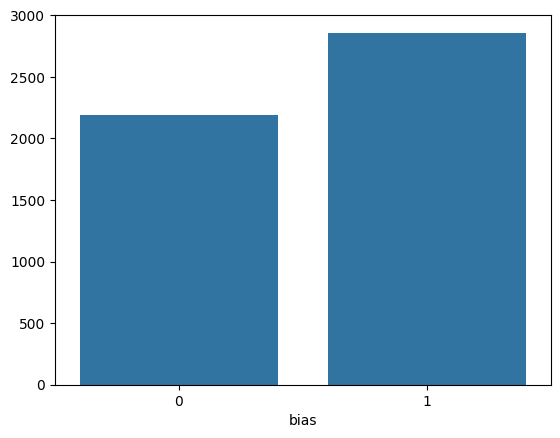

In [4]:
bias_vals = train_data['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

In [5]:
train_data[train_data["title"]=="Juche"]
title_counts = train_data['title'].value_counts()

# Filter rows where title appears exactly two times
filtered_df = train_data[train_data['title'].map(title_counts) == 2]

display(filtered_df)

,title,text_content,bias
0,Electroconvulsive therapy,electroconvulsive therapy electroconvulsive th...,0
1,Juche,"juche juche (주체), or kimilsungism , ...",0
2,Special pleading,special pleading special pleading (or claimin...,0
3,Chrislam,"chrislam chrislam is, as the name implies, a ...",0
4,Black box,black box a black box refers to any system u...,0
...,...,...,...
5037,Putinism,presidency of vladimir putin vladimir putin ...,1
5038,Sniffex,sniffex sniffex and sniffex plus are fake ...,1
5039,Four-term fallacy,fallacy of four terms the fallacy of four ter...,1
5040,Nosode,homeopathy homeopathy or homoeopathy is a...,1


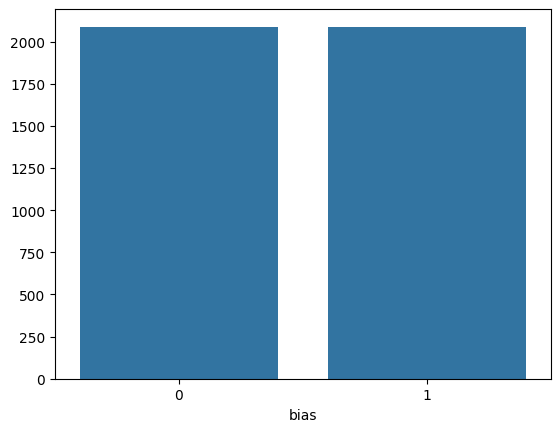

In [6]:
train_data=filtered_df.copy()
bias_vals = train_data['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

## Preprocessing All Dataset

### creating the train data and validation train data (80% and 20% respectively)

In [7]:
duplicate_titles = train_data['title'].value_counts()[train_data['title'].value_counts() == 2].index.tolist()

train = pd.DataFrame(columns=train_data.columns)
valid_train = pd.DataFrame(columns=train_data.columns)

i=0
for title in duplicate_titles:

    # Get rows with the current title
    title_rows = train_data[train_data['title'] == title]
    
    if i<len(duplicate_titles)*0.9:
    # Append to the respective DataFrames
        train = pd.concat([train, title_rows])
    else:
        valid_train = pd.concat([valid_train, title_rows])
    i+=1


In [8]:
print(train["bias"].value_counts())
print(valid_train["bias"].value_counts())

bias
0    1881
1    1881
Name: count, dtype: int64
bias
0    208
1    208
Name: count, dtype: int64


### Tokenize the text content of all dataset

In [9]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=400)
    inputs.to(device)
    global a
    a+=1
    print(f"{a} over {len(train)+len(valid_train)+len(pred_data)}")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.cpu().mean(dim=1).squeeze().numpy()


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased') #base or large
model = BertModel.from_pretrained('bert-large-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device) #should be cuda, if not it will take too much time

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<?, ?B/s]
c:\Users\adrie\anaconda3\envs\envADA\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adrie\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.60MB/s]
tokenizer

cuda


In [11]:
a=0
train["embedding"] = train["text_content"].apply(get_bert_embedding)
valid_train["embedding"] = valid_train["text_content"].apply(get_bert_embedding)
pred_data["embedding"] = pred_data["text_content"].apply(get_bert_embedding)
prediction = list(pred_data["embedding"])

1 over 8782
2 over 8782
3 over 8782
4 over 8782
5 over 8782
6 over 8782
7 over 8782
8 over 8782
9 over 8782
10 over 8782
11 over 8782
12 over 8782
13 over 8782
14 over 8782
15 over 8782
16 over 8782
17 over 8782
18 over 8782
19 over 8782
20 over 8782
21 over 8782
22 over 8782
23 over 8782
24 over 8782
25 over 8782
26 over 8782
27 over 8782
28 over 8782
29 over 8782
30 over 8782
31 over 8782
32 over 8782
33 over 8782
34 over 8782
35 over 8782
36 over 8782
37 over 8782
38 over 8782
39 over 8782
40 over 8782
41 over 8782
42 over 8782
43 over 8782
44 over 8782
45 over 8782
46 over 8782
47 over 8782
48 over 8782
49 over 8782
50 over 8782
51 over 8782
52 over 8782
53 over 8782
54 over 8782
55 over 8782
56 over 8782
57 over 8782
58 over 8782
59 over 8782
60 over 8782
61 over 8782
62 over 8782
63 over 8782
64 over 8782
65 over 8782
66 over 8782
67 over 8782
68 over 8782
69 over 8782
70 over 8782
71 over 8782
72 over 8782
73 over 8782
74 over 8782
75 over 8782
76 over 8782
77 over 8782
78 over 

## Classification methods : We use Support Vector Machine for Classification (SVM-C)

In [12]:
#Helper function for calculating accuracy on the test set.
def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)

### Creating the classifier model and cross validation

In [13]:
X_train = list(train["embedding"])
y_train = train["bias"]
X_test =  list(valid_train["embedding"])
y_test = valid_train["bias"]

In [14]:
print(len(X_train), len(y_train))

3762 3762


In [15]:
cross_val="false"

if cross_val=="true":
    svc = SVC()

    param_grid = {
        'C': [0.1, 1, 10, 100],            # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
        'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
        'coef0': [0.0, 1.0],
    }

    grid_search=GridSearchCV(svc, param_grid, cv=5, scoring="accuracy")

    grid_search.fit(X_train, list(y_train))
    best_param= grid_search.best_params_
    
else:
    best_param={'C': 1, 'coef0': 0.0, 'gamma': 'scale', 'kernel': 'linear'}

svc =SVC(**best_param, probability=True)

svc.fit(X_train,y_train.astype(float))

print("Accuracy of the model trained = %0.2f %%"%(acc(y_train,svc.predict(X_train))*100)) #Accuracy of model depending on the fitting
print("Accuracy of the model with test data = %0.2f %%"%(acc(y_test,svc.predict(X_test))*100)) #Accuracy of the model on verifying data

Accuracy of the model trained = 96.07 %
Accuracy of the model with test data = 92.55 %


In [16]:
best_param

{'C': 1, 'coef0': 0.0, 'gamma': 'scale', 'kernel': 'linear'}

In [17]:
#del train, valid_train, X_train,X_test, y_train,y_test

In [18]:
class_probabilities=svc.predict_proba(prediction)

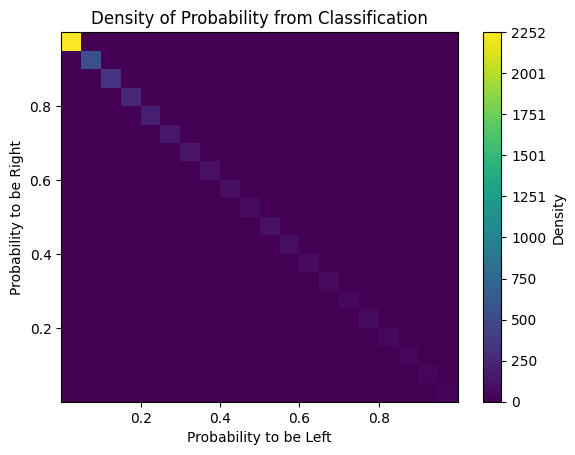

In [19]:
plt.figure()

#density plot
hist, xedges, yedges = np.histogram2d(class_probabilities[:, 0], class_probabilities[:, 1], bins=(20, 20))

#Colorbar

plt.pcolormesh(xedges, yedges, hist.T, cmap="viridis")  # Color-blind friendly

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Density')

# Set labels and title
plt.xlabel("Probability to be Left")
plt.ylabel("Probability to be Right")
plt.title("Density of Probability from Classification")

# Display legend with colorbar values
legend_values = np.linspace(hist.min(), hist.max(), num=10)
cbar.set_ticks(legend_values)
cbar.set_ticklabels([f'{int(value)}' for value in legend_values])

# Show the plot
plt.show()

In [20]:
pred_labels=[]
threshold=2/3

for i in range(len(class_probabilities)):
    if class_probabilities[i,0]>threshold:
      label=0
    elif class_probabilities[i,1]>threshold:
      label=2
    else:
      label=1
    pred_labels.append(label)


print(len(pred_labels))

4604


In [21]:
pred_data["Bias"] = pred_labels

selected_columns=["title","Bias"]

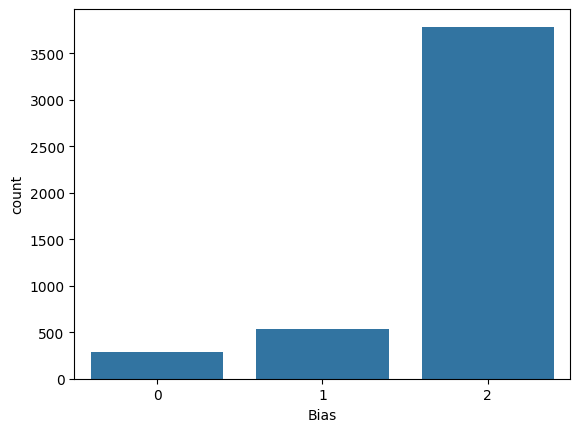

In [22]:
plt.figure()
sns.barplot(x=pred_data["Bias"].value_counts().index, y=pred_data["Bias"].value_counts())
plt.show()

In [23]:
pred_data["Bias"].value_counts()

Bias
2    3785
1     532
0     287
Name: count, dtype: int64

In [24]:
pred_data[selected_columns].to_csv("./political_bias_final_BERT.csv", index=False)